In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('max_column', 1000)
pd.set_option('max_rows', 1000)

In [2]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
sample_sub = pd.read_csv('Sample_Submission.csv')

In [3]:
sample_sub.head()

,SalesInMillions
0,1.497533
1,2.368795
2,2.630505
3,2.506086
4,1.970574


In [4]:
train.head()

,ID,CONSOLE,YEAR,CATEGORY,PUBLISHER,RATING,CRITICS_POINTS,USER_POINTS,SalesInMillions
0,2860,ds,2008,role-playing,Nintendo,E,2.833333,0.303704,1.779257
1,731,wii,2012,simulation,Konami Digital Entertainment,E10+,13.200000,1.640000,0.215050
2,495,pc,2019,shooter,Activision,M,4.562500,0.006410,0.534402
3,2641,ps2,2002,sports,Electronic Arts,E,4.181818,0.326923,1.383964
4,811,ps3,2013,action,Activision,M,2.259259,0.032579,0.082671


In [5]:
test.head()

,ID,CONSOLE,YEAR,CATEGORY,PUBLISHER,RATING,CRITICS_POINTS,USER_POINTS
0,4310,ps2,2008,action,Tecmo Koei,T,3.928571,0.482353
1,4011,psp,2007,strategy,Atari,E10+,5.538462,0.071795
2,2185,ps2,2004,shooter,Electronic Arts,T,3.034483,0.062044
3,1644,x,2006,action,Electronic Arts,E,2.913043,0.880000
4,188,3ds,2011,racing,Ubisoft,E10+,1.162162,0.183333


In [6]:
train.shape, test.shape

((3506, 9), (1503, 8))

## Feature Engineering

In [7]:
train['points'] = train['CRITICS_POINTS'] * train['USER_POINTS']
test['points'] = test['CRITICS_POINTS'] * test['USER_POINTS']

In [8]:
train['Critic_point_cat_mean'] = train.groupby('CATEGORY')['CRITICS_POINTS'].transform('mean')
train['Critic_point_cat_std'] = train.groupby('CATEGORY')['CRITICS_POINTS'].transform('std')

test['Critic_point_cat_mean'] = test.groupby('CATEGORY')['CRITICS_POINTS'].transform('mean')
test['Critic_point_cat_std'] = test.groupby('CATEGORY')['CRITICS_POINTS'].transform('std')

In [9]:
train['user_point_cat_mean'] = train.groupby('CATEGORY')['USER_POINTS'].transform('mean')
train['user_point_cat_std'] = train.groupby('CATEGORY')['USER_POINTS'].transform('std')

test['user_point_cat_mean'] = test.groupby('CATEGORY')['USER_POINTS'].transform('mean')
test['user_point_cat_std'] = test.groupby('CATEGORY')['USER_POINTS'].transform('std')

In [10]:
train['n_year_rating'] = train.groupby('YEAR')['RATING'].transform('nunique')
test['n_year_rating'] = test.groupby('YEAR')['RATING'].transform('nunique')

In [11]:
train['n_console_category'] = train.groupby('PUBLISHER')['CATEGORY'].transform('nunique')
test['n_console_category'] = test.groupby('CONSOLE')['CATEGORY'].transform('nunique')

In [12]:
train['n_publisher_console'] = train.groupby('PUBLISHER')['CONSOLE'].transform('nunique')
test['n_publisher_console'] = test.groupby('PUBLISHER')['CONSOLE'].transform('nunique')

In [13]:
train['user_publisher_mean'] = train.groupby('PUBLISHER')['USER_POINTS'].transform('mean')
train['user_publisher_std'] = train.groupby('PUBLISHER')['USER_POINTS'].transform('std')

test['user_publisher_mean'] = test.groupby('PUBLISHER')['USER_POINTS'].transform('mean')
test['user_publisher_std'] = test.groupby('PUBLISHER')['USER_POINTS'].transform('std')

In [14]:
train['USER_POINTS'] = np.log1p(train['USER_POINTS'])
test['USER_POINTS'] = np.log1p(test['USER_POINTS'])

In [15]:
train['CRITICS_POINTS'] = np.log1p(train['CRITICS_POINTS'])
test['CRITICS_POINTS'] = np.log1p(test['CRITICS_POINTS'])

In [16]:
train.head()

,ID,CONSOLE,YEAR,CATEGORY,PUBLISHER,RATING,CRITICS_POINTS,USER_POINTS,SalesInMillions,points,Critic_point_cat_mean,Critic_point_cat_std,user_point_cat_mean,user_point_cat_std,n_year_rating,n_console_category,n_publisher_console,user_publisher_mean,user_publisher_std
0,2860,ds,2008,role-playing,Nintendo,E,1.343735,0.265209,1.779257,0.860494,3.030737,2.530770,0.258094,0.372459,4,12,6,0.194803,0.302443
1,731,wii,2012,simulation,Konami Digital Entertainment,E10+,2.653242,0.970779,0.215050,21.648000,4.637810,3.459926,0.447938,0.399493,4,12,13,0.501914,0.524219
2,495,pc,2019,shooter,Activision,M,1.716048,0.006390,0.534402,0.029247,2.655283,2.097455,0.253722,0.392199,4,11,16,0.441186,0.466400
3,2641,ps2,2002,sports,Electronic Arts,E,1.645156,0.282863,1.383964,1.367133,4.460985,3.110016,0.544185,0.508669,3,12,16,0.356344,0.412553
4,811,ps3,2013,action,Activision,M,1.181500,0.032060,0.082671,0.073605,3.853440,3.469185,0.362329,0.417877,4,11,16,0.441186,0.466400


In [17]:
X = train.drop(columns='SalesInMillions')
y = train['SalesInMillions']
tes = test

## Modelling

In [19]:
cate_features_index = np.where(X.dtypes == object) [0]; cate_features_index

array([1, 3, 4, 5])

In [20]:
err=[]
y_pred_totcb=[]

fold=KFold(n_splits=5, random_state=1234)
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    m1 = CatBoostRegressor(iterations=50000, learning_rate=0.01, random_seed=1234, eval_metric='RMSE')
    m1.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=500,verbose=100,cat_features=cate_features_index)
    preds = m1.predict(X_test)
    print("err: ",np.sqrt(mean_squared_error(y_test,preds)))
    err.append(np.sqrt(mean_squared_error(y_test,preds)))
    p2 = m1.predict(tes)
    y_pred_totcb.append(p2)
np.mean(err)

0:	learn: 2.6436070	test: 2.6436070	test1: 1.7488780	best: 1.7488780 (0)	total: 82.4ms	remaining: 1h 8m 40s
100:	learn: 2.2648078	test: 2.2782165	test1: 1.6279626	best: 1.6279626 (100)	total: 688ms	remaining: 5m 39s
200:	learn: 2.0285070	test: 2.0532824	test1: 1.5745291	best: 1.5745291 (200)	total: 1.24s	remaining: 5m 6s
300:	learn: 1.8997695	test: 1.9220228	test1: 1.5612457	best: 1.5589707 (287)	total: 1.77s	remaining: 4m 52s
400:	learn: 1.7907047	test: 1.8170910	test1: 1.5671953	best: 1.5589707 (287)	total: 2.34s	remaining: 4m 49s
500:	learn: 1.7054885	test: 1.7372361	test1: 1.5799522	best: 1.5589707 (287)	total: 2.94s	remaining: 4m 50s
600:	learn: 1.6358173	test: 1.6756477	test1: 1.5922449	best: 1.5589707 (287)	total: 3.65s	remaining: 5m
700:	learn: 1.5841654	test: 1.6323576	test1: 1.6005942	best: 1.5589707 (287)	total: 4.36s	remaining: 5m 6s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 1.558970737
bestIteration = 287

Shrink model to first 288 iterations.
err:

6600:	learn: 0.7948923	test: 1.0490529	test1: 3.0751749	best: 3.0751380 (6594)	total: 38.4s	remaining: 4m 12s
6700:	learn: 0.7894185	test: 1.0466666	test1: 3.0752941	best: 3.0751380 (6594)	total: 39.1s	remaining: 4m 12s
6800:	learn: 0.7841344	test: 1.0447143	test1: 3.0737688	best: 3.0736566 (6793)	total: 39.7s	remaining: 4m 12s
6900:	learn: 0.7790876	test: 1.0421642	test1: 3.0731834	best: 3.0730329 (6885)	total: 40.3s	remaining: 4m 11s
7000:	learn: 0.7735424	test: 1.0395673	test1: 3.0731281	best: 3.0729201 (6970)	total: 40.8s	remaining: 4m 10s
7100:	learn: 0.7682493	test: 1.0370718	test1: 3.0726132	best: 3.0726099 (7098)	total: 41.4s	remaining: 4m 10s
7200:	learn: 0.7634373	test: 1.0347423	test1: 3.0725876	best: 3.0725143 (7194)	total: 42s	remaining: 4m 9s
7300:	learn: 0.7581647	test: 1.0315965	test1: 3.0725663	best: 3.0723812 (7241)	total: 42.6s	remaining: 4m 9s
7400:	learn: 0.7531578	test: 1.0291568	test1: 3.0727691	best: 3.0723812 (7241)	total: 43.2s	remaining: 4m 8s
7500:	learn: 0.

14000:	learn: 0.5176603	test: 0.9251854	test1: 3.0619181	best: 3.0619181 (14000)	total: 1m 22s	remaining: 3m 31s
14100:	learn: 0.5147129	test: 0.9237599	test1: 3.0617182	best: 3.0616881 (14096)	total: 1m 22s	remaining: 3m 30s
14200:	learn: 0.5122033	test: 0.9228884	test1: 3.0621070	best: 3.0616881 (14096)	total: 1m 23s	remaining: 3m 29s
14300:	learn: 0.5094437	test: 0.9216764	test1: 3.0619107	best: 3.0616881 (14096)	total: 1m 23s	remaining: 3m 29s
14400:	learn: 0.5069285	test: 0.9210047	test1: 3.0620130	best: 3.0616881 (14096)	total: 1m 24s	remaining: 3m 28s
14500:	learn: 0.5044702	test: 0.9199964	test1: 3.0618261	best: 3.0616881 (14096)	total: 1m 25s	remaining: 3m 28s
14600:	learn: 0.5021485	test: 0.9189929	test1: 3.0616233	best: 3.0616199 (14577)	total: 1m 25s	remaining: 3m 27s
14700:	learn: 0.4996582	test: 0.9179949	test1: 3.0614991	best: 3.0614723 (14694)	total: 1m 26s	remaining: 3m 27s
14800:	learn: 0.4971790	test: 0.9169607	test1: 3.0615411	best: 3.0614056 (14725)	total: 1m 26s	r

5500:	learn: 0.9159941	test: 1.2791610	test1: 1.3926993	best: 1.3926837 (5499)	total: 34.1s	remaining: 4m 35s
5600:	learn: 0.9090034	test: 1.2760134	test1: 1.3928218	best: 1.3926270 (5575)	total: 34.7s	remaining: 4m 35s
5700:	learn: 0.9024692	test: 1.2729396	test1: 1.3925591	best: 1.3924758 (5651)	total: 35.3s	remaining: 4m 34s
5800:	learn: 0.8953690	test: 1.2695253	test1: 1.3922410	best: 1.3921469 (5789)	total: 36s	remaining: 4m 34s
5900:	learn: 0.8896995	test: 1.2669481	test1: 1.3924417	best: 1.3921160 (5830)	total: 36.7s	remaining: 4m 34s
6000:	learn: 0.8837672	test: 1.2647842	test1: 1.3928993	best: 1.3921160 (5830)	total: 37.3s	remaining: 4m 33s
6100:	learn: 0.8774922	test: 1.2626282	test1: 1.3929730	best: 1.3921160 (5830)	total: 37.9s	remaining: 4m 33s
6200:	learn: 0.8717369	test: 1.2600683	test1: 1.3930596	best: 1.3921160 (5830)	total: 38.6s	remaining: 4m 32s
6300:	learn: 0.8664660	test: 1.2584315	test1: 1.3930457	best: 1.3921160 (5830)	total: 39.2s	remaining: 4m 31s
Stopped by o

3500:	learn: 1.0294856	test: 1.2735980	test1: 1.8822205	best: 1.8819156 (3490)	total: 21.5s	remaining: 4m 45s
3600:	learn: 1.0202838	test: 1.2686719	test1: 1.8813542	best: 1.8813542 (3600)	total: 22.5s	remaining: 4m 49s
3700:	learn: 1.0113355	test: 1.2638204	test1: 1.8801607	best: 1.8801350 (3699)	total: 23.4s	remaining: 4m 52s
3800:	learn: 1.0034841	test: 1.2600237	test1: 1.8788724	best: 1.8788724 (3800)	total: 24s	remaining: 4m 51s
3900:	learn: 0.9944934	test: 1.2545854	test1: 1.8771599	best: 1.8771599 (3900)	total: 24.5s	remaining: 4m 50s
4000:	learn: 0.9856067	test: 1.2497931	test1: 1.8767395	best: 1.8763067 (3970)	total: 25.4s	remaining: 4m 52s
4100:	learn: 0.9782408	test: 1.2468153	test1: 1.8754962	best: 1.8754962 (4100)	total: 26s	remaining: 4m 51s
4200:	learn: 0.9696325	test: 1.2425086	test1: 1.8753874	best: 1.8748002 (4149)	total: 26.9s	remaining: 4m 53s
4300:	learn: 0.9618916	test: 1.2382791	test1: 1.8755580	best: 1.8748002 (4149)	total: 27.6s	remaining: 4m 53s
4400:	learn: 0

1.8735622699564076

In [21]:
col = ['CONSOLE','CATEGORY','PUBLISHER','RATING']
for i in col:
    X[col] = X[col].astype('category')
    tes[col] = tes[col].astype('category')

In [22]:
err1=[]
y_pred_totcb1=[]

fold=KFold(n_splits=5, random_state=1234)
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    m2 = LGBMRegressor(n_estimators=1000, max_depth=-1, learning_rate=0.006, random_state=42)
    m2.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=500,verbose=100,)
    preds = m2.predict(X_test)
    print("err: ",np.sqrt(mean_squared_error(y_test,preds)))
    err1.append(np.sqrt(mean_squared_error(y_test,preds)))
    p2 = m2.predict(tes)
    y_pred_totcb1.append(p2)
np.mean(err1)

Training until validation scores don't improve for 500 rounds
[100]	training's l2: 5.43639	valid_1's l2: 2.52519
[200]	training's l2: 4.74461	valid_1's l2: 2.39104
[300]	training's l2: 4.19516	valid_1's l2: 2.33957
[400]	training's l2: 3.77845	valid_1's l2: 2.38257
[500]	training's l2: 3.49073	valid_1's l2: 2.42447
[600]	training's l2: 3.2497	valid_1's l2: 2.46853
[700]	training's l2: 3.03947	valid_1's l2: 2.50996
[800]	training's l2: 2.85681	valid_1's l2: 2.55461
Early stopping, best iteration is:
[303]	training's l2: 4.17824	valid_1's l2: 2.33767
err:  1.5289446531512123
Training until validation scores don't improve for 500 rounds
[100]	training's l2: 3.11981	valid_1's l2: 13.6532
[200]	training's l2: 2.57603	valid_1's l2: 12.7584
[300]	training's l2: 2.22627	valid_1's l2: 12.1811
[400]	training's l2: 2.00431	valid_1's l2: 11.8451
[500]	training's l2: 1.81841	valid_1's l2: 11.4579
[600]	training's l2: 1.6707	valid_1's l2: 11.1816
[700]	training's l2: 1.54597	valid_1's l2: 10.9342
[8

1.9707683527940507

In [23]:
X['RATING'] = X['RATING'].replace({'RP':'T', 'K-A':'T'})
tes['RATING'] = tes['RATING'].replace({'AO':'T'})

In [24]:
X = pd.get_dummies(data=X, columns=['RATING','CATEGORY'], drop_first=True)
tes = pd.get_dummies(data=tes, columns=['RATING','CATEGORY'], drop_first=True)

In [25]:
from sklearn.preprocessing import LabelEncoder
encode = ['PUBLISHER','CONSOLE']
le = LabelEncoder()
for col in encode:
    X[col] = le.fit_transform(X[col])
    tes[col] = le.fit_transform(tes[col])

In [26]:
err2=[]
y_pred_totcb2=[]

fold=KFold(n_splits=5, random_state=1234)
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    m3 = XGBRegressor(n_estimators=1000, max_depth=5, learning_rate=0.07, random_state=42)
    m3.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=100,verbose=100,)
    preds = m3.predict(X_test)
    print("err: ",np.sqrt(mean_squared_error(y_test,preds)))
    err2.append(np.sqrt(mean_squared_error(y_test,preds)))
    p2 = m3.predict(tes)
    y_pred_totcb2.append(p2)
np.mean(err2)

[0]	validation_0-rmse:3.01102	validation_1-rmse:2.32145
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:1.10089	validation_1-rmse:1.70253
Stopping. Best iteration:
[23]	validation_0-rmse:1.66565	validation_1-rmse:1.61735

err:  1.6173494288756791
[0]	validation_0-rmse:2.48180	validation_1-rmse:4.20740
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:1.05123	validation_1-rmse:3.31243
[200]	validation_0-rmse:0.88310	validation_1-rmse:3.30233
[300]	validation_0-rmse:0.75930	validation_1-rmse:3.29648
[400]	validation_0-rmse:0.66105	validation_1-rmse:3.29282
Stopping. Best iteration:
[382]	validation_0-rmse:0.67557	validation_1-rmse:3.29138

err:  3.291379744869903
[0]	validation_0-rmse:2.96814	validation_1-rmse:2.53844
Mult

2.1063601484677634

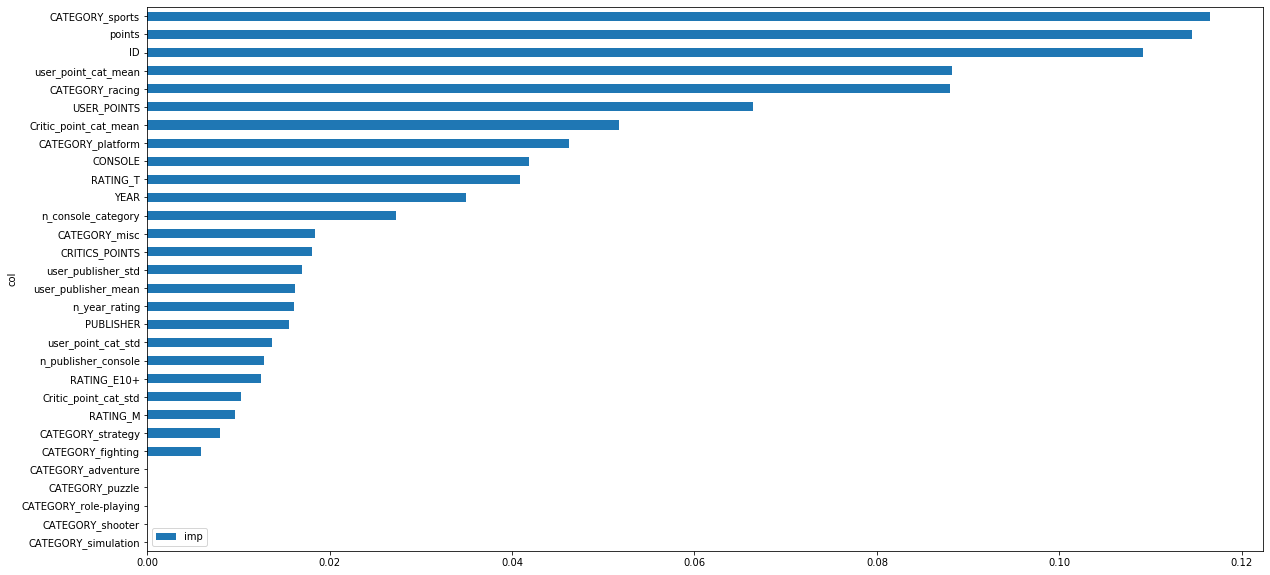

In [28]:
## Check for the feature importance 
fea_imp = pd.DataFrame({'imp':m3.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
plt.savefig('catboost_feature_importance.png')

In [29]:
predic1 = np.mean(y_pred_totcb, 0)
predic2 = np.mean(y_pred_totcb1, 0)
predic3 = np.mean(y_pred_totcb2, 0)

In [30]:
a = {"SalesInMillions": predic1}
b = {"SalesInMillions": predic2}
c = {"SalesInMillions": predic3}

sub1 = pd.DataFrame(data=a)
sub2 = pd.DataFrame(data=b)
sub3 = pd.DataFrame(data=c)

In [31]:
sub1.head()

,SalesInMillions
0,1.720739
1,2.009305
2,3.350372
3,1.961982
4,2.050956


In [32]:
sub2.head()

,SalesInMillions
0,1.936299
1,2.517155
2,3.523646
3,1.962767
4,1.883871


In [33]:
sub3.head()

,SalesInMillions
0,1.402619
1,2.203543
2,2.774559
3,1.693101
4,2.365861


### Averaging

In [34]:
ave = 0.8*sub1 + 0.2*sub3

In [35]:
ave.head()

,SalesInMillions
0,1.657115
1,2.048153
2,3.235209
3,1.908206
4,2.113937


In [36]:
ave.to_csv('submission.csv', index=False)